In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline

In [2]:
def NGD(x,alpha,beta,K,g,phi):
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [3]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [4]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i]=np.sum(MIsingle)
    return timeshift,MIvalue

In [5]:
# generate OU
def OU(tau,fc,dt,Seed):
    Tot=300
    T=np.arange(dt,Tot,dt)
    D = 4
    L=np.zeros(len(T))
    for i in range(len(T)-1):
        L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*Seed[i]

    # filtering
    if fc!='no':
        b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
        Lf = signal.filtfilt(b, a, L)
        x=Lf
    else:
        x=L
    return x

In [6]:
def FFT_quick(data,dt):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(data), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

In [7]:
def xcorr_quick(x,y,window_size):
    corr_same=np.correlate(x,y,'same')/len(x)
    corr=corr_same[int(len(corr_same+1)/2)-int(window_size/dt):int(len(corr_same+1)/2)+int(window_size/dt)]
    timelag=np.arange(-int(window_size/dt),int(window_size/dt))*dt
    return timelag,corr

In [8]:
# def xcorr_quick(x,y,window_size):
#     lags=np.arange(-int(window_size/dt),int(window_size/dt)+1e-5)
#     lags=lags.astype(int)
#     corr=np.zeros(len(lags))
#     timelag=lags*dt
#     for icorr in range(len(lags)):
#         if lags[icorr]<0:
#             corr[icorr]=np.sum(x[:-1+lags[icorr]]*y[1-lags[icorr]:])
#         elif lags[icorr]==0:
#             corr[icorr]=np.sum(x*y)
#         else:
#             corr[icorr]=np.sum(x[lags[icorr]:]*y[:-lags[icorr]])
#     return timelag,corr

In [9]:
path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
file=[]

file.append(['OU_tau=100ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=100ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
      'OU_tau=100ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
     'OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=100ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat'])

file.append(['OU_tau=600ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=600ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
      'OU_tau=600ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
     'OU_tau=600ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=600ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat'])

file.append(['OU_tau=1000ms_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=1000ms_cutoff=10_19-Apr-2020_0_sort_unit1_MI.mat',\
      'OU_tau=1000ms_cutoff=7_19-Apr-2020_0_sort_unit1_MI.mat',\
     'OU_tau=1000ms_cutoff=4_19-Apr-2020_0_sort_unit1_MI.mat','OU_tau=1000ms_cutoff=2_19-Apr-2020_0_sort_unit1_MI.mat'])

In [10]:
MIlist=[[[] for n in range(np.size(file,1))] for n in range(np.size(file,0))]
expdata=[[[] for n in range(np.size(file,1))] for n in range(np.size(file,0))]
channel=38
for n in range(len(file)):
    for i in range(5):
        expdata=loadmat(path+file[n][i])
        MI_data=expdata['MI']
        TS=expdata['TimeShift']
        TS=TS[0]
        MIlist[n][i]=MI_data[0][channel][0]

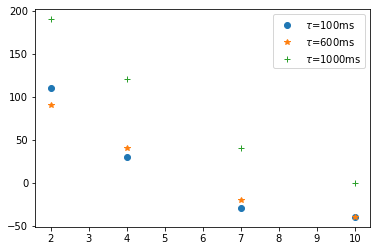

In [11]:
# find MI peak positions
sym=['o','*','+']
fc=np.array([float('inf'),10,7,4,2])
for n in range(np.size(MIlist,0)):
    TSpeak_exp=np.zeros(np.size(MIlist,1))
    for i in range(np.size(MIlist,1)):
        loc2=np.argmax(MIlist[n][i][TS>-100])
        TSpeak_exp[i]=TS[TS>-100][loc2]
    plt.plot(fc,TSpeak_exp,sym[n])
plt.legend((r'$\tau$=100ms',r'$\tau$=600ms',r'$\tau$=1000ms'))

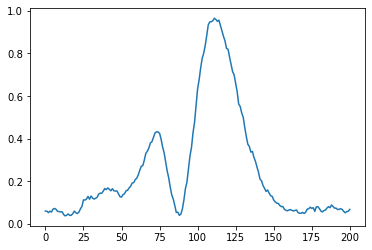

In [30]:
plt.plot(MIlist[0][4])

(200.0, 300.0)

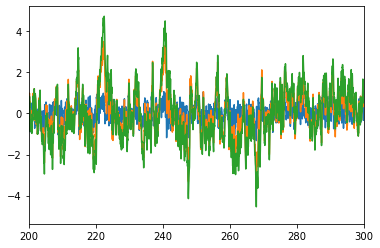

In [13]:
# generate OU input (different tau and different cutoff frequency)
tau_set=[0.1,0.6,1]
fc=['no',10,7,4,2]
dt=0.01
Tot=300
T=np.arange(dt,Tot,dt)
mu, sigma = 0, 1
ran_seed=np.random.normal(mu,sigma,len(T))
x_set=[[OU(tau_set[j],fc[i],dt,ran_seed) for i in range(len(fc))] for j in range(len(tau_set))]
# mean_inten=10 # set a mean intensity of the stimulus
# for i in range(len(tau_set)): 
#     for j in range(len(fc)):
#         x_set[i][j]=mean_inten/5*x_set[i][j]/np.std(x_set[i][j])
#         x_set[i][j]=x_set[i][j]-np.mean(x_set[i][j])+mean_inten
        
for i in range(len(tau_set)):
    plt.plot(T,x_set[i][1])
plt.xlim(200,300)

In [14]:
alpha,beta,K,g=6,1.6,22,10
y_set=[[NGD(x_set[i][j],alpha,beta,K,g,1)[0] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
z_set=[[NGD(x_set[i][j],alpha,beta,K,g,1)[1] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
# y_set is a 2d list 
# y_set[diffrent tau][different fc] 

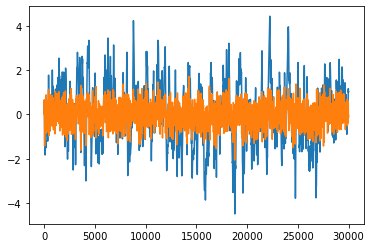

In [15]:
plt.plot(x_set[2][4])
plt.plot(y_set[2][4])

In [16]:
MIsim=[[MI(EqualState(x_set[j][i],8),EqualState(y_set[j][i],8),dt,[-1,1])[1] for i in range(np.size(x_set,1))] for j in range(np.size(x_set,0))]
timeshift=np.arange(-1,1.0001,dt)

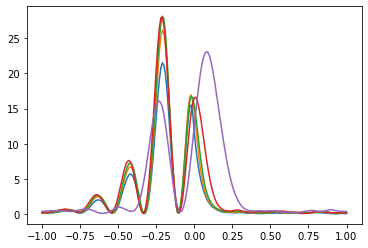

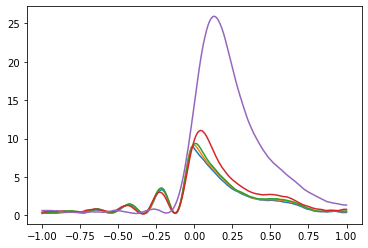

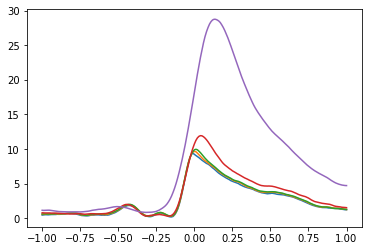

In [17]:
for i in range(np.size(x_set,1)):
    plt.plot(timeshift,MIsim[0][i])
plt.xlim()
plt.show()

for i in range(np.size(x_set,1)):
    plt.plot(timeshift,MIsim[1][i])
plt.xlim()
plt.show()

for i in range(np.size(x_set,1)):
    plt.plot(timeshift,MIsim[2][i])
plt.xlim()
plt.show()

In [18]:
# cross correlation
window_size=3
corr_set=[[[] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
for i in range(np.size(x_set,0)):
    for j in range(np.size(x_set,1)):
        corr_same=np.correlate(x_set[i][j],y_set[i][j],'same')/len(x_set[i][j])
        corr_set[i][j]=corr_same[int(len(corr_same+1)/2)-int(window_size/dt):int(len(corr_same+1)/2)+int(window_size/dt)]
#         corr_set[i][j]=corr_set[i][j]/max(abs(corr_set[i][j]))
timelag=np.arange(-int(window_size/dt),int(window_size/dt))*dt

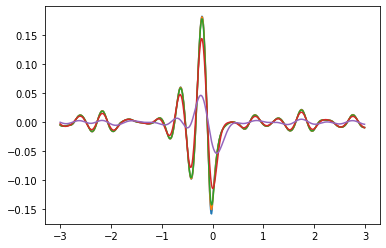

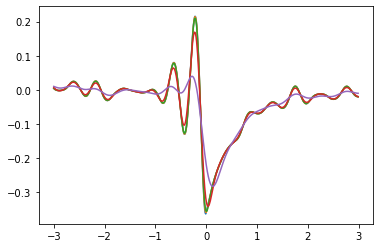

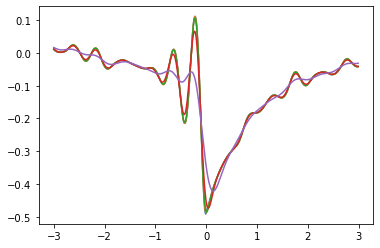

In [19]:
for i in range(np.size(x_set,1)):    
    plt.plot(timelag,-corr_set[0][i])
plt.show()
for i in range(np.size(x_set,1)):
    plt.plot(timelag,-corr_set[1][i])
plt.show()
for i in range(np.size(x_set,1)):    
    plt.plot(timelag,-corr_set[2][i])
plt.show()

In [20]:
path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
fileSTA=[]

fileSTA.append(['OU_tau=100ms_19-Apr-2020_0_sort_unit1_STA.mat','OU_tau=100ms_cutoff=10_19-Apr-2020_0_sort_unit1_STA.mat',\
      'OU_tau=100ms_cutoff=7_19-Apr-2020_0_sort_unit1_STA.mat',\
     'OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1_STA.mat','OU_tau=100ms_cutoff=2_19-Apr-2020_0_sort_unit1_STA.mat'])

fileSTA.append(['OU_tau=600ms_19-Apr-2020_0_sort_unit1_STA.mat','OU_tau=600ms_cutoff=10_19-Apr-2020_0_sort_unit1_STA.mat',\
      'OU_tau=600ms_cutoff=7_19-Apr-2020_0_sort_unit1_STA.mat',\
     'OU_tau=600ms_cutoff=4_19-Apr-2020_0_sort_unit1_STA.mat','OU_tau=600ms_cutoff=2_19-Apr-2020_0_sort_unit1_STA.mat'])

fileSTA.append(['OU_tau=1000ms_19-Apr-2020_0_sort_unit1_STA.mat','OU_tau=1000ms_cutoff=10_19-Apr-2020_0_sort_unit1_STA.mat',\
      'OU_tau=1000ms_cutoff=7_19-Apr-2020_0_sort_unit1_STA.mat',\
     'OU_tau=1000ms_cutoff=4_19-Apr-2020_0_sort_unit1_STA.mat','OU_tau=1000ms_cutoff=2_19-Apr-2020_0_sort_unit1_STA.mat'])


In [21]:
STAlist=[[[] for n in range(np.size(fileSTA,1))] for n in range(np.size(fileSTA,0))]
# expdataSTA=[[[] for n in range(np.size(fileSTA,1))] for n in range(np.size(fileSTA,0))]
for n in range(len(fileSTA)):
    for i in range(5):
        expdataSTA=loadmat(path+fileSTA[n][i])
        STA_data=expdataSTA['STAAAAA'] 
        TS=expdataSTA['TimeShift']
        TS=TS[0][0][0]
        STAlist[n][i]=STA_data[0][channel][0]

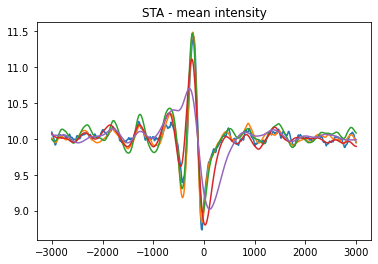

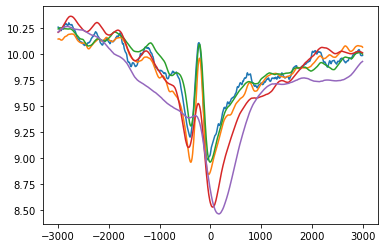

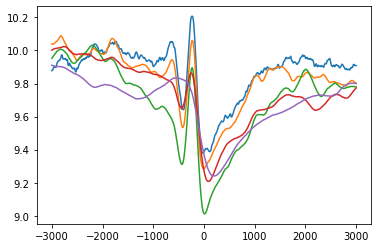

In [22]:
for i in range(np.size(fileSTA,1)):
    plt.plot(TS,STAlist[0][i])
plt.title('STA - mean intensity')
plt.show()
    
for i in range(np.size(fileSTA,1)):
    plt.plot(TS,STAlist[1][i])
plt.show()
    
for i in range(np.size(fileSTA,1)):
    plt.plot(TS,STAlist[2][i])
plt.show()

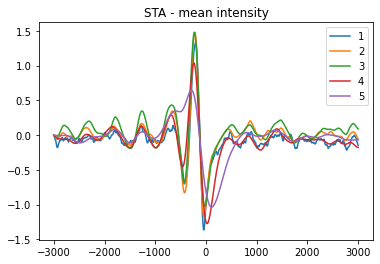

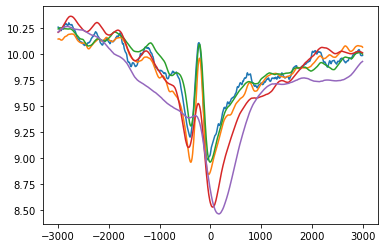

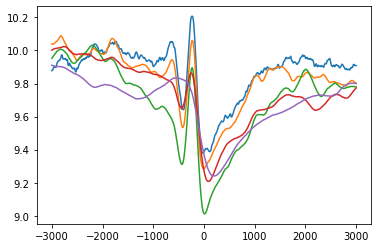

In [23]:
for i in range(np.size(fileSTA,1)):
    plt.plot(TS,STAlist[0][i]-STAlist[0][i][0])
plt.title('STA - mean intensity')
plt.legend(('1','2','3','4','5'))
plt.show()

for i in range(np.size(fileSTA,1)):
    plt.plot(TS,STAlist[1][i]) #-STAlist[1][i][0]
plt.show()
    
for i in range(np.size(fileSTA,1)):
    plt.plot(TS,STAlist[2][i]) #-STAlist[2][i][0]
plt.show()

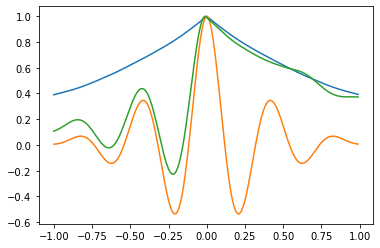

In [24]:
# plt.plot(x_set[2][0])
# cross correlation
corr_same=np.correlate(x_set[2][0],x_set[2][0],'same')/len(x_set[2][0])
corr=corr_same[int(len(corr_same+1)/2)-int(1/dt):int(len(corr_same+1)/2)+int(1/dt)]
timelag=np.arange(-int(1/dt),int(1/dt))*dt
plt.plot(timelag,corr/max(corr))
# plt.plot(x_set[2][0])
corr_same=np.correlate(y_set[2][0],y_set[2][0],'same')/len(x_set[2][0])
corr=corr_same[int(len(corr_same+1)/2)-int(1/dt):int(len(corr_same+1)/2)+int(1/dt)]
timelag=np.arange(-int(1/dt),int(1/dt))*dt
plt.plot(timelag,corr/max(corr))

# plt.plot(x_set[2][0])
# cross correlation
corr_same=np.correlate(x_set[2][0],y_set[2][0],'same')/len(x_set[2][0])
corr=corr_same[int(len(corr_same+1)/2)-int(1/dt):int(len(corr_same+1)/2)+int(1/dt)]
timelag=np.arange(-int(1/dt),int(1/dt))*dt
plt.plot(timelag,corr/max(corr))

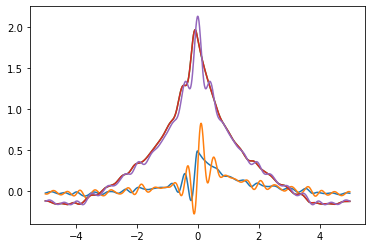

In [25]:
x=x_set[2][0]
y=y_set[2][0]
z=z_set[2][0]

timelag,corrxy=xcorr_quick(x,y,5)
timelag,corrzy=xcorr_quick(z,y,5)
timelag,corrxz=xcorr_quick(x,z,5)
timelag,corrxx=xcorr_quick(x,z,5)
timelag,corrzz=xcorr_quick(z,z,5)

plt.plot(timelag,corrxy)
plt.plot(timelag,corrzy)
plt.plot(timelag,corrxz)
plt.plot(timelag,corrxx)
plt.plot(timelag,corrzz)

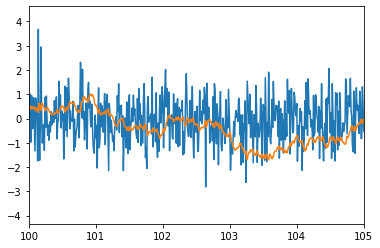

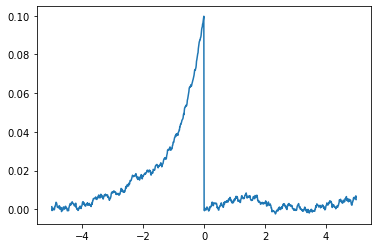

In [26]:
mu, sigma = 0, 1
xran2=np.random.normal(mu,sigma,len(T))
yran2=np.zeros(len(xran2))
for j in range(len(x)-1):
    dyran2=dt*(-1*yran2[j]+g*xran2[j])
    yran2[j+1]=yran2[j]+dyran2
plt.plot(T,xran2)
plt.plot(T,yran2)
plt.xlim(100,105)
plt.show()

timelag,corr_relax=xcorr_quick(xran2,yran2,5)
plt.plot(timelag,corr_relax)

## result for $\dot{y}=-y+gx$ 

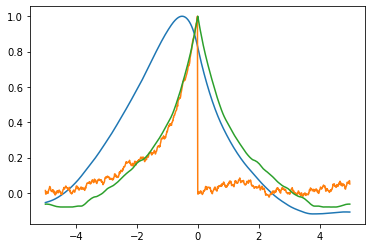

In [27]:

# mu, sigma = 0, 1
# xran3=np.random.normal(mu,sigma,len(T))
# x3=OU(1,4,dt,xran3)
x3=x
y3=np.zeros(len(x3))
for j in range(len(x)-1):
    dy3=dt*(-1*y3[j]+g*x3[j])
    y3[j+1]=y3[j]+dy3
# plt.plot(T,x3)
# plt.plot(T,y3)
# plt.xlim(100,105)
# plt.show()

# cross correlation 
timelag,corr_relax_OU=xcorr_quick(x3,y3,5)
timelag,corrx3x3=xcorr_quick(x3,x3,5)
plt.plot(timelag,corr_relax_OU/max(corr_relax_OU))
plt.plot(timelag,corr_relax/max(corr_relax))
plt.plot(timelag,corrx3x3/max(corrx3x3))

## generate NGD kernel

In [28]:
alpha,beta,K,g=6,1.6,22,10
total_loop=1
corr_window=5
corr_sum=np.zeros(2*int(corr_window/dt)+1)
for num_loop in range(total_loop):
    mu, sigma = 0, 1
    xran4=np.random.normal(mu,sigma,len(T))
    y4,z4=NGD(xran4,alpha,beta,K,g,1)
    timelag100,Crand=xcorr_quick(xran4,y4,corr_window)
    corr_sum+=Crand
corr_sum=corr_sum/total_loop
    
# plt.plot(T,xran4)
# plt.plot(T,y4)
# plt.xlim(100,105)
# plt.show()

plt.plot(timelag100,corr_sum[::-1])
plt.xlim(-5,5)


ValueError: operands could not be broadcast together with shapes (1001,) (1000,) (1001,) 

## result for NGD model

In [ ]:
temp_kernel=corr_sum[::-1]/max(corr_sum)
x=x_set[2][0]
plt.plot(timelag100,temp_kernel)
timelag100,Cxx=xcorr_quick(x,x,5)
plt.plot(timelag100,Cxx/max(Cxx))
plt.xlim(-5,5)
plt.show()

timelag1,Cxxk=xcorr_quick(Cxx,temp_kernel,5)
plt.plot(timelag1,Cxxk/max(Cxxk))
plt.xlim(-1,1)
# plt.plot(timelag,corrxy/max(corrxy))
# plt.plot(timelag100,temp_kernel/max(temp_kernel))
# plt.plot(timelag100,Cxx/max(Cxx))
# plt.xlim(-5,5)

In [ ]:
# plt.plot(Cxx)
plt.plot(timelag100,temp_kernel)
plt.xlim(-5,5)
corr_same=np.correlate(Cxx,temp_kernel,'same')/len(x)
corr_xy_equi=corr_same[int(len(corr_same+1)/2)-int(window_size/dt):int(len(corr_same+1)/2)+int(window_size/dt)]
timelag_equi=np.arange(-int(window_size/dt),int(window_size/dt))*dt
# plt.plot(timelag_equi,corr_xy_equi)


In [ ]:
print(len(Cxx),len(temp_kernel))